## Importing Dependencies

In [1]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Using GPU with nvidia cuda to enhance tensorflow
#I use this just to increase my execution time. The model can be trained even without this cell.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading and pre-processing data

In [3]:
classes = os.listdir('data/train_angle_2')

In [4]:
classes

['Back', 'Front', 'Side']

In [5]:
#use Imagedatagenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)


train_generator = datagen.flow_from_directory(
        'data/train_angle_2',
        target_size=(250, 250),
        batch_size=32,
        class_mode='categorical',
        subset='training')  # This will be used for training

validation_generator = datagen.flow_from_directory(
        'data/train_angle_2',
        target_size=(250, 250),
        batch_size=32,
        class_mode='categorical',
        subset='validation')



Found 415 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


## Creating model with convolution layers

In [6]:
no_of_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250,250, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', name='Dense'),
    tf.keras.layers.Dense(no_of_classes, activation='softmax', name='Dense_finalLayer')
])

print(model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

## Training the model

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator, validation_data=validation_generator, epochs=40,
                    steps_per_epoch=len(train_generator), callbacks=[early_stopping])

Epoch 1/40
10/13 [======================>.......] - ETA: 1s - loss: 1.2913 - accuracy: 0.4451

C:\Users\Nikesh\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - 11s 557ms/step - loss: 1.2180 - accuracy: 0.4843 - val_loss: 1.0058 - val_accuracy: 0.6117
Epoch 2/40
13/13 [==============================] - 7s 505ms/step - loss: 0.9153 - accuracy: 0.6169 - val_loss: 1.0272 - val_accuracy: 0.6311
Epoch 3/40
13/13 [==============================] - 6s 495ms/step - loss: 0.8577 - accuracy: 0.6361 - val_loss: 0.9568 - val_accuracy: 0.6893
Epoch 4/40
13/13 [==============================] - 8s 597ms/step - loss: 0.7721 - accuracy: 0.6651 - val_loss: 0.8318 - val_accuracy: 0.7184
Epoch 5/40
13/13 [==============================] - 7s 519ms/step - loss: 0.7455 - accuracy: 0.6771 - val_loss: 0.8097 - val_accuracy: 0.6990
Epoch 6/40
13/13 [==============================] - 6s 474ms/step - loss: 0.6531 - accuracy: 0.7494 - val_loss: 0.6700 - val_accuracy: 0.8155
Epoch 7/40
13/13 [==============================] - 6s 467ms/step - loss: 0.5242 - accuracy: 0.7880 - val_loss: 0.4534 - val_accuracy: 0.8835
Epoch 8/40
13/13

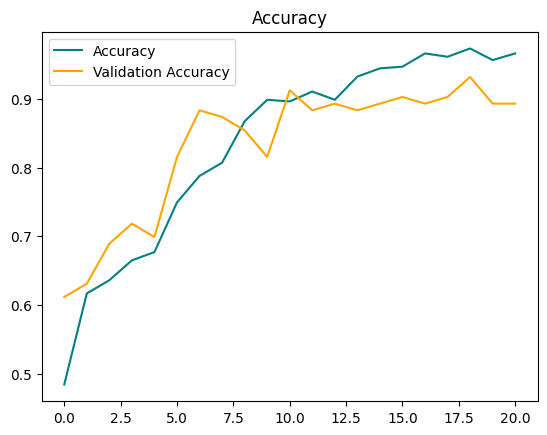

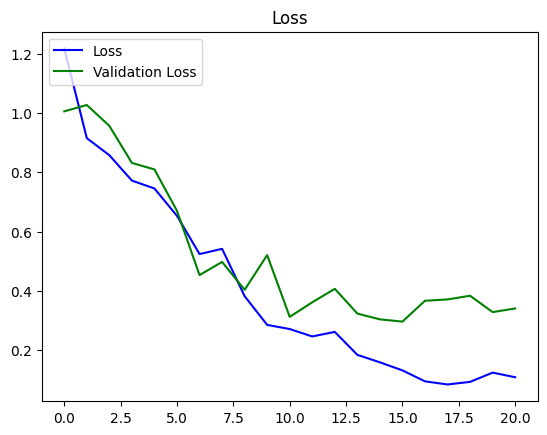

In [16]:
fig = plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='teal', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()



plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='Loss')
plt.plot(history.history['val_loss'], color='green', label='Validation Loss')
plt.legend(loc="upper left")

plt.show()

## Validation

C:\Users\Nikesh\AppData\Local\Temp\ipykernel_14748\2176546517.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized = img_rgba.resize((250, 250), Image.ANTIALIAS)


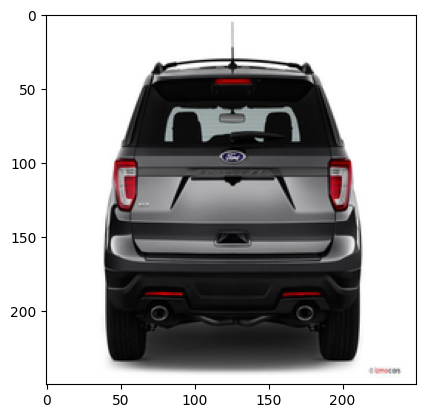

In [14]:
img = cv2.imread('data/train/Back_Ford_Explorer_2016-2019/2018_ford_explorer_rearview.jpg')


from PIL import Image
img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_rgba = img_pil.convert('RGBA')

# Resize the image to the required input size
resized = img_rgba.resize((250, 250), Image.ANTIALIAS)

# Convert the image back to RGB format (if needed for displaying with matplotlib)
resized_rgb = resized.convert('RGB')
plt.imshow(np.array(resized_rgb))
plt.show()



In [15]:
resized = np.array(resized_rgb) / 255.0  # Convert to float and rescale to [0, 1]
resized = np.expand_dims(resized, 0)  # Add batch dimension
resized_tensor = tf.convert_to_tensor(resized, dtype=tf.float32)

test_predict = model.predict(resized_tensor)

# Get the predicted class label
predicted_class_index = np.argmax(test_predict[0])
predicted_class = classes[predicted_class_index]
print('Predicted Car:', predicted_class)

1/1 [==============================] - 0s 70ms/step
Predicted Car: Back


## Saving model and converting as tflite model

In [10]:
model.save('angle_detection_model.h5')

In [11]:
from keras.models import load_model
angle_detection_model = load_model('angle_detection_model.h5')

In [12]:
conv = tf.lite.TFLiteConverter.from_keras_model(angle_detection_model)
tfmodel = conv.convert()

INFO:tensorflow:Assets written to: C:\Users\Nikesh\AppData\Local\Temp\tmpqg2wnzem\assets


INFO:tensorflow:Assets written to: C:\Users\Nikesh\AppData\Local\Temp\tmpqg2wnzem\assets


In [13]:
open("angle_detection_model_lite.tflite","wb").write(tfmodel)

22680804